In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  InputLayer, Conv2D, Lambda, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import os
import numpy as np
from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

from UNet_Fourier_Facilities import Fourier_Images


In [84]:
model_cnn = tf.keras.models.load_model("./models/single_rgb_image")


## UNet-Model

In [85]:
# model_cnn = tf.keras.models.load_model("./models/single_rgb_image")


In [86]:
# img1 = Image.open(
#     "D:\Main\MA_PROGR\Data\Train\LED_Wand_Aufnahmen\Alias\LED_Wand_20001.png")
# img1 = np.asarray(img1)/255
# img1 = img1.reshape(1, 60, 60, 3)
# res1 = model.predict(img1)
# print(res1)


In [87]:
np.random.seed = 42
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3


## Load Images

In [88]:
TRAIN_FILMED_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_5_pics\\filmed"
TRAIN_CLEAN_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_5_pics\\clean"
# TEST_PATH = "./Data/data-science-bowl-2018/stage1_test/"


In [89]:
train_filmed_imgs = []
train_clean_imgs = []

In [90]:
OFFSET = 400

for addr_filmed in os.listdir(TRAIN_FILMED_PATH):
    img = plt.imread(f"{TRAIN_FILMED_PATH}\{addr_filmed}")
    train_filmed_imgs.append(
        img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET])

for addr_clean in os.listdir(TRAIN_CLEAN_PATH):
    img = plt.imread(f"{TRAIN_CLEAN_PATH}\{addr_clean}")
    train_clean_imgs.append(
        img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET])


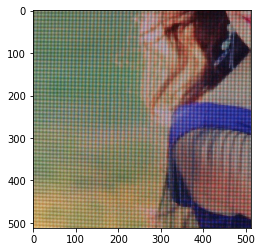

In [91]:
plt.imshow(train_filmed_imgs[0])
plt.show()


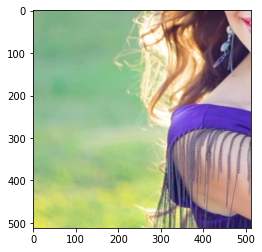

In [92]:
plt.imshow(train_clean_imgs[0])
plt.show()


## Build U-Net-Model

In [93]:
inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), batch_size=None)

# Hier werden Preprocessing-Schritte ausgeführt
# s ist hier dann Differnzbild (Pixelraum_Fourier)
s = Lambda(lambda x: x / 255)(inputs)


# Contraction path
c1 = Conv2D(
    16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = Conv2DTranspose(
    128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(
    64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu',
            kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(
    32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(
    16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model_u_net = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy',
#               metrics=['accuracy'])
model_u_net.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 512, 512, 1)  0           input_50[0][0]                   
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 512, 512, 16) 160         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_33 (Dropout)            (None, 512, 512, 16) 0           conv2d_69[0][0]                  
____________________________________________________________________________________________

## Train Model

In [94]:
# ppm: postprocessing model 

def create_postprocessing_model():

    ppm_input_img_clean = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT, 3), batch_size=1)
    ppm_input_img_filmed = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT, 3), batch_size=1)
    ppm_input_unet_output = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT), batch_size=1)
    ppm_input_img_clean_complex_r = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT), batch_size=1, dtype=tf.complex64)
    ppm_input_img_clean_complex_g = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT), batch_size=1, dtype=tf.complex64)
    ppm_input_img_clean_complex_b = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT), batch_size=1, dtype=tf.complex64)
    ppm_input_img_filmed_complex_r = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT), batch_size=1, dtype=tf.complex64)
    ppm_input_img_filmed_complex_g = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT), batch_size=1, dtype=tf.complex64)
    ppm_input_img_filmed_complex_b = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT), batch_size=1, dtype=tf.complex64)


    ones = tf.ones((IMG_WIDTH, IMG_WIDTH))
    zeros = tf.zeros((IMG_WIDTH, IMG_WIDTH))
    ones_t2c = tf.complex(ones, zeros)
    u_net_output_t2c = tf.complex(ppm_input_unet_output, zeros)

    # FORMEL: (1 - out) * clean + out * filmed
    # out == mask 
    # t2c -> transfered to complex


    def soft_blending(clean, filmed, ones_t2c=ones_t2c, u_net_output_t2c=u_net_output_t2c):
        zw1 = tf.math.subtract(ones_t2c, u_net_output_t2c)
        zw1 = tf.math.multiply(zw1, clean)

        zw2 = tf.multiply(u_net_output_t2c, filmed)
        return tf.math.add(zw1, zw2)

    img_processed_complex_fourier_r = soft_blending(
        ppm_input_img_clean_complex_r, ppm_input_img_filmed_complex_r)

    img_processed_complex_fourier_g = soft_blending(
        ppm_input_img_clean_complex_g, ppm_input_img_filmed_complex_g)

    img_processed_complex_fourier_b = soft_blending(
        ppm_input_img_clean_complex_b, ppm_input_img_filmed_complex_b)



    # # img_processed_px_fourier = tf.math.log(                     # zum anschauen
    # #     tf.math.abs(img_processed_complex_fourier_r))

    # ----------- INVERSE FOURIER TRANSFORMATION -----------

    img_processed_r = tf.signal.ifft2d(
        img_processed_complex_fourier_r
    )

    img_processed_g = tf.signal.ifft2d(
        img_processed_complex_fourier_g
    )
    img_processed_b = tf.signal.ifft2d(
        img_processed_complex_fourier_b
    )

    


    # 3 Einzelkanäle zu einem RGB Bild
    img_processed_r = tf.math.abs(img_processed_r)/255
    img_processed_g = tf.math.abs(img_processed_g)/255
    img_processed_b = tf.math.abs(img_processed_b)/255

    img_processed_rgb = tf.stack(
        [img_processed_r, img_processed_g, img_processed_b], axis=3)

    postprocess_model = tf.keras.Model(inputs=[
        ppm_input_img_clean, 
        ppm_input_img_filmed,
        ppm_input_unet_output,
        ppm_input_img_clean_complex_r ,
        ppm_input_img_clean_complex_g ,
        ppm_input_img_clean_complex_b ,
        ppm_input_img_filmed_complex_r, 
        ppm_input_img_filmed_complex_g,
        ppm_input_img_filmed_complex_b
    ], outputs = [img_processed_rgb], name="postprocess_model")

    # postprocess_model.summary()
    return postprocess_model


In [101]:
# Custom train loop

UNET_OUTPUT_PATH = "D:\\Main\\MA_PROGR\\Data\\UNET_Output\\Session01"
SHOW_OUTPUTS = False
SAVE_MASKS = True



RGB_WEIGHTS = [0.299, 0.587, 0.114]

execute_UNet_model = tf.function(model_u_net)
execute_cnn_model = tf.function(model_cnn)
execute_postprocessing_model = tf.function(create_postprocessing_model())

batch_size = 1

num_epochs = 1
optimizer = tf.keras.optimizers.Adam()
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss_fn = tf.keras.losses.mean_absolute_error
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

train_writer = tf.summary.create_file_writer("u_net_logs/train/")
test_writer = tf.summary.create_file_writer("u_net_logs/test/")

y_true = tf.constant(0, dtype=tf.float16, name="y_true")


for epoch in range(num_epochs):
    print(f"Start of epoch {epoch}")

    train_step = 0
    # X_train: müsste bei mir ein Iterator sein, welcher 1 Bild zurückgibt (1, IMG_WIDTH, IMG_WIDTH, 3)
    for x_filmed, x_clean in tqdm(zip(train_filmed_imgs, train_clean_imgs), desc="training...", ascii=False, ncols=75):

        # ---- Preprocessing mit Python ----

        if SHOW_OUTPUTS:
            print("######################### Train step #################################")

        fourier_handler = Fourier_Images(x_filmed, x_clean)

        img_filmed_r, img_filmed_g, img_filmed_b = fourier_handler.split_RGB_2_Grayscale(
            x_filmed)
        img_clean_r, img_clean_g, img_clean_b = fourier_handler.split_RGB_2_Grayscale(
            x_clean)

        img_filmed_complex_r = fourier_handler.grayscale_2_Fourier(
            img_filmed_r)
        img_filmed_complex_g = fourier_handler.grayscale_2_Fourier(
            img_filmed_g)
        img_filmed_complex_b = fourier_handler.grayscale_2_Fourier(
            img_filmed_b)

        img_clean_complex_r = fourier_handler.grayscale_2_Fourier(
            img_filmed_r)
        img_clean_complex_g = fourier_handler.grayscale_2_Fourier(
            img_filmed_g)
        img_clean_complex_b = fourier_handler.grayscale_2_Fourier(
            img_filmed_b)

        x_filmed_fourier_px, x_clean_fourier_px, differenzbild_fourier_px = fourier_handler.generate_mask_from_images()



        if SHOW_OUTPUTS:
            print("differenzbild_fourier_px: ")
            # print(differenzbild_fourier_px)
            plt.imshow(differenzbild_fourier_px, cmap="gray")
            plt.show()


        if SAVE_MASKS:
            plt.imsave(
                f"{UNET_OUTPUT_PATH}\\differenzbild_fourier_px_{train_step}.png", differenzbild_fourier_px)

        differenzbild_fourier_px = differenzbild_fourier_px.reshape(
            1, IMG_WIDTH, IMG_HEIGHT, 1)



        del(fourier_handler)

        with tf.GradientTape() as tape:

            # ----------- HIER STARTET U-NET-MODEL -----------

            u_net_output = execute_UNet_model(
                differenzbild_fourier_px, training=True)

        

            if SAVE_MASKS:
                plt.imsave(f"{UNET_OUTPUT_PATH}\\u_net_output_{train_step}.png",  
                np.asarray(u_net_output).reshape(IMG_HEIGHT, IMG_WIDTH), cmap="gray")

            print("u_net_output: ")
            print(u_net_output)

            # ----------- ALPHA-BLENDING -----------


            # CASTING IST NICHT ABLEITBAR - KANN MAN NICHT VERWENDEN!!
            # u_net_output = tf.cast(u_net_output, tf.int32)
            # u_net_output = tf.cast(u_net_output, tf.bool)

            # FORMEL: (1 - out) * clean + out * filmed
            # t2c -> transfered to complex

            if SHOW_OUTPUTS:
                print("x_clean: ")
                plt.imshow(x_clean)
                plt.show()

                print("x_filmed: ")
                plt.imshow(x_filmed)
                plt.show()

            x_clean = x_clean.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3))
            x_filmed = x_filmed.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3))



            u_net_output = tf.reshape(
                u_net_output, shape=(IMG_WIDTH, IMG_HEIGHT))

            img_clean_complex_r = img_clean_complex_r.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
            img_clean_complex_g = img_clean_complex_g.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
            img_clean_complex_b = img_clean_complex_b.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
            img_filmed_complex_r = img_filmed_complex_r.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
            img_filmed_complex_g = img_filmed_complex_g.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))
            img_filmed_complex_b = img_filmed_complex_b.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))

            image_processed_rgb = execute_postprocessing_model([
                x_clean ,
                x_filmed ,
                u_net_output,
                img_clean_complex_r ,
                img_clean_complex_g ,
                img_clean_complex_b ,
                img_filmed_complex_r ,
                img_filmed_complex_g ,
                img_filmed_complex_b ,
            ])

            # ----------- Make prediction with CNN -----------


            # print("image_processed_rgb: ")
            # print(image_processed_rgb)



            # cnn_input = image_processed_rgb[:, 0:60, 0:60]
            # cnn_input = tf.reshape(cnn_input, shape=(1, 60, 60, 3))

            # ----------- Feed multiple Buckets in CNN for predicting amount of alias -----------

            if SHOW_OUTPUTS:
                print("image_processed_rgb: ")
                # print(np.array(image_processed_rgb).reshape(IMG_HEIGHT, IMG_WIDTH, 3))
                plt.imshow(np.array(image_processed_rgb).reshape(
                    IMG_HEIGHT, IMG_WIDTH, 3))
                plt.show()


            def create_multiple_buckets_to_feed_them_into_CNN(tensor):

                BATCH_SIZE = 1
                NUM_BOXES = 15
                CROP_SIZE = (60, 60)

                boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
                box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,
                                                maxval=BATCH_SIZE, dtype=tf.int32)
                
                output = tf.image.crop_and_resize(
                    tensor, boxes, box_indices, CROP_SIZE)
                return output

            cnn_input = create_multiple_buckets_to_feed_them_into_CNN(image_processed_rgb)

            if SHOW_OUTPUTS:
                print("cnn_input: ")
                print(cnn_input)




            y_pred = execute_cnn_model(cnn_input)

            y_pred = tf.math.reduce_mean(
                y_pred, keepdims=True
            )

        
            if SHOW_OUTPUTS:
                print("y_pred: ")
                print(y_pred)



            # ----------- Calc loss -----------

            y_true = tf.zeros(batch_size, 1)

            loss = loss_fn(y_true, y_pred)
            # print("loss: ")
            # print(loss)

        gradients = tape.gradient(loss, model_u_net.trainable_weights)
        # print("gradients: ")
        # print(gradients)
        optimizer.apply_gradients(
            zip(gradients, model_u_net.trainable_weights))
        # acc_metric.update_state(
        #     y_batch.reshape(-1, 128, 128, 1), u_net_output)

        # with train_writer.as_default():
        #     tf.summary.scalar("Loss", loss, step=train_step)
        #     tf.summary.scalar(
        #         "Accuracy", acc_metric.result(), step=train_step,
        #     )
        train_step += 1

# train_acc = acc_metric.result()
# print(f"Accuracy over epoch {train_acc}")
# acc_metric.reset_states()


Start of epoch 0


training...: 0it [00:00, ?it/s]

u_net_output: 
tf.Tensor(
[[[[0.4999966 ]
   [0.4999984 ]
   [0.49999538]
   ...
   [0.49999976]
   [0.4999971 ]
   [0.49999794]]

  [[0.4999968 ]
   [0.499996  ]
   [0.4999994 ]
   ...
   [0.4999961 ]
   [0.5000006 ]
   [0.49999732]]

  [[0.49999776]
   [0.49999717]
   [0.50000024]
   ...
   [0.5000002 ]
   [0.49999896]
   [0.4999984 ]]

  ...

  [[0.4999977 ]
   [0.500002  ]
   [0.4999888 ]
   ...
   [0.49999967]
   [0.4999976 ]
   [0.49999875]]

  [[0.49999568]
   [0.4999965 ]
   [0.4999959 ]
   ...
   [0.5       ]
   [0.499997  ]
   [0.49999568]]

  [[0.49999794]
   [0.4999918 ]
   [0.49999133]
   ...
   [0.49999958]
   [0.5000003 ]
   [0.500002  ]]]], shape=(1, 512, 512, 1), dtype=float32)


training...: 1it [00:03,  3.03s/it]

u_net_output: 
tf.Tensor(
[[[[0.4999962 ]
   [0.4999963 ]
   [0.49999422]
   ...
   [0.49999693]
   [0.49999863]
   [0.49999785]]

  [[0.49999678]
   [0.4999972 ]
   [0.4999984 ]
   ...
   [0.4999945 ]
   [0.4999971 ]
   [0.49999797]]

  [[0.4999937 ]
   [0.4999969 ]
   [0.4999937 ]
   ...
   [0.4999989 ]
   [0.4999984 ]
   [0.49999845]]

  ...

  [[0.4999976 ]
   [0.49999902]
   [0.49999702]
   ...
   [0.4999975 ]
   [0.49999756]
   [0.50000083]]

  [[0.49999645]
   [0.5000034 ]
   [0.49999407]
   ...
   [0.49999863]
   [0.49999383]
   [0.4999996 ]]

  [[0.49999774]
   [0.50000155]
   [0.4999996 ]
   ...
   [0.49999914]
   [0.49999878]
   [0.50000364]]]], shape=(1, 512, 512, 1), dtype=float32)


training...: 2it [00:05,  2.46s/it]

u_net_output: 
tf.Tensor(
[[[[0.49999753]
   [0.49999714]
   [0.4999961 ]
   ...
   [0.49999726]
   [0.49999705]
   [0.49999756]]

  [[0.49999788]
   [0.49999934]
   [0.49999824]
   ...
   [0.49999547]
   [0.49999732]
   [0.49999845]]

  [[0.49999794]
   [0.49999884]
   [0.4999991 ]
   ...
   [0.5000023 ]
   [0.49999636]
   [0.49999845]]

  ...

  [[0.4999953 ]
   [0.49999976]
   [0.49999434]
   ...
   [0.49999994]
   [0.49999997]
   [0.50000006]]

  [[0.4999944 ]
   [0.4999991 ]
   [0.4999952 ]
   ...
   [0.5000004 ]
   [0.50000095]
   [0.5000009 ]]

  [[0.4999988 ]
   [0.4999928 ]
   [0.50000036]
   ...
   [0.4999996 ]
   [0.5000009 ]
   [0.5000013 ]]]], shape=(1, 512, 512, 1), dtype=float32)


training...: 3it [00:07,  2.24s/it]

u_net_output: 
tf.Tensor(
[[[[0.4999976 ]
   [0.49999815]
   [0.4999957 ]
   ...
   [0.49999636]
   [0.49999705]
   [0.49999705]]

  [[0.49999547]
   [0.4999996 ]
   [0.49999624]
   ...
   [0.49999714]
   [0.4999996 ]
   [0.49999723]]

  [[0.49999684]
   [0.49999887]
   [0.4999982 ]
   ...
   [0.5000002 ]
   [0.49999952]
   [0.4999995 ]]

  ...

  [[0.49999645]
   [0.5000012 ]
   [0.4999935 ]
   ...
   [0.49999848]
   [0.4999952 ]
   [0.5000001 ]]

  [[0.49999794]
   [0.4999991 ]
   [0.49999338]
   ...
   [0.5000035 ]
   [0.49999496]
   [0.4999982 ]]

  [[0.49999613]
   [0.50000167]
   [0.49999863]
   ...
   [0.50000334]
   [0.500004  ]
   [0.5000008 ]]]], shape=(1, 512, 512, 1), dtype=float32)


training...: 4it [00:09,  2.15s/it]

u_net_output: 
tf.Tensor(
[[[[0.49999666]
   [0.5000005 ]
   [0.49999595]
   ...
   [0.4999979 ]
   [0.49999723]
   [0.49999753]]

  [[0.49999663]
   [0.4999956 ]
   [0.49999696]
   ...
   [0.4999975 ]
   [0.4999979 ]
   [0.50000006]]

  [[0.49999937]
   [0.49999964]
   [0.4999993 ]
   ...
   [0.5000016 ]
   [0.4999978 ]
   [0.49999908]]

  ...

  [[0.49999774]
   [0.4999963 ]
   [0.49999702]
   ...
   [0.5000045 ]
   [0.50000054]
   [0.5000001 ]]

  [[0.49999613]
   [0.49999803]
   [0.4999953 ]
   ...
   [0.49999744]
   [0.49999604]
   [0.4999986 ]]

  [[0.50000024]
   [0.4999998 ]
   [0.5000034 ]
   ...
   [0.50000185]
   [0.5000032 ]
   [0.50000066]]]], shape=(1, 512, 512, 1), dtype=float32)


training...: 5it [00:11,  2.23s/it]


In [96]:
test_img = img[400:528, 400:528,:]
test_img = np.array(test_img).reshape(1, 128 , 128 , 3)

# plt.imshow(test_img)

test_img= tf.convert_to_tensor(test_img, dtype=tf.float32)

test_img


<tf.Tensor: shape=(1, 128, 128, 3), dtype=float32, numpy=
array([[[[136., 173., 139.],
         [136., 173., 139.],
         [135., 173., 139.],
         ...,
         [134., 176., 140.],
         [135., 177., 141.],
         [135., 178., 141.]],

        [[135., 173., 138.],
         [135., 173., 138.],
         [135., 173., 138.],
         ...,
         [135., 177., 140.],
         [135., 177., 140.],
         [135., 177., 140.]],

        [[134., 173., 137.],
         [134., 173., 137.],
         [134., 173., 137.],
         ...,
         [135., 177., 140.],
         [135., 177., 140.],
         [135., 177., 140.]],

        ...,

        [[133., 177., 151.],
         [133., 177., 150.],
         [133., 177., 149.],
         ...,
         [137., 187., 152.],
         [138., 187., 152.],
         [138., 187., 151.]],

        [[133., 177., 151.],
         [133., 177., 150.],
         [133., 177., 149.],
         ...,
         [136., 188., 151.],
         [137., 187., 151.],
         

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


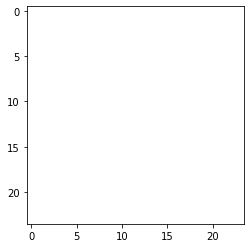

In [97]:
import tensorflow as tf
BATCH_SIZE = 1
NUM_BOXES = 3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
CHANNELS = 3
CROP_SIZE = (24, 24)

test_img = img[400:528, 400:528, :]
test_img = np.array(test_img).reshape(1, 128, 128, 3)

# plt.imshow(test_img)

test_img = tf.convert_to_tensor(test_img, dtype=tf.float32)
image = test_img
boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
# plt.imshow(np.array(image).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
# plt.show()
box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,
                                maxval=BATCH_SIZE, dtype=tf.int32)
output = tf.image.crop_and_resize(image, boxes, box_indices, CROP_SIZE)
output.shape  # => (5, 24, 24, 3)

plt.imshow(output[2])
